In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [61]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=3, suppress=True)

In [3]:
df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [5]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [6]:
data = df.drop('date', axis=1)
data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1.00
1,0,25,2552,899.00,1.00
2,0,25,2552,899.00,-1.00
3,0,25,2554,"1,709.05",1.00
4,0,25,2555,"1,099.00",1.00


In [8]:
items = items.drop('item_name', axis=1)

In [9]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [10]:
data = data.join(items.set_index('item_id'), on='item_id')

In [11]:
data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.00,37
1,0,25,2552,899.00,1.00,58
2,0,25,2552,899.00,-1.00,58
3,0,25,2554,"1,709.05",1.00,58
4,0,25,2555,"1,099.00",1.00,56


In [15]:
item_cnt_month = data.groupby(['shop_id', 'date_block_num', 'item_id'], as_index=False)\
    .agg({'item_cnt_day': 'sum'}).rename({'item_cnt_day': 'item_cnt_month'}, axis=1)

In [16]:
item_cnt_month.head()

,shop_id,date_block_num,item_id,item_cnt_month
0,0,0,32,6.00
1,0,0,33,3.00
2,0,0,35,1.00
3,0,0,43,1.00
4,0,0,51,2.00


In [20]:
shops = list(set(item_cnt_month.shop_id))
shops[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

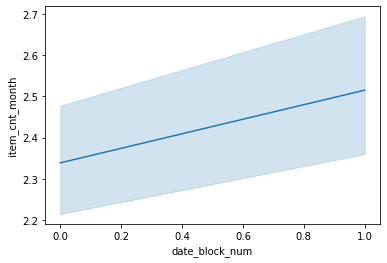

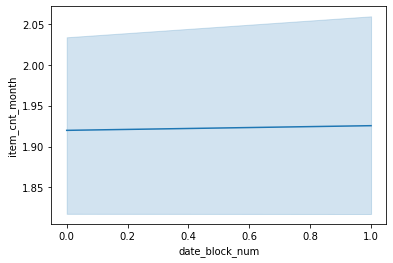

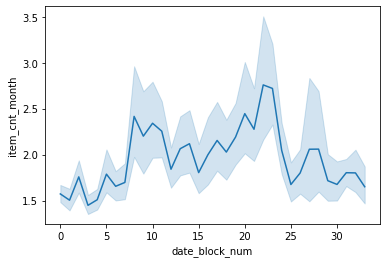

KeyboardInterrupt: 

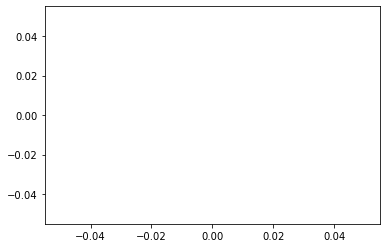

In [23]:
for shop_id in shops:
    
    shop_data = item_cnt_month[item_cnt_month.shop_id == shop_id]
    
    sns.lineplot(data=shop_data, x='date_block_num', y='item_cnt_month')
    plt.show()

In [25]:
mean_data = item_cnt_month.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_month' : 'mean'})\
    .rename({'item_cnt_month': 'mean'}, axis=1)

In [27]:
mean_data.head()

,shop_id,date_block_num,mean
0,0,0,2.34
1,0,1,2.52
2,1,0,1.92
3,1,1,1.93
4,2,0,1.57


In [28]:
std_data = item_cnt_month.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_month' : 'std'})\
    .rename({'item_cnt_month': 'std'}, axis=1)

In [29]:
std_data.head()

,shop_id,date_block_num,std
0,0,0,3.44
1,0,1,4.21
2,1,0,2.18
3,1,1,2.55
4,2,0,1.35


In [30]:
data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.00,37
1,0,25,2552,899.00,1.00,58
2,0,25,2552,899.00,-1.00,58
3,0,25,2554,"1,709.05",1.00,58
4,0,25,2555,"1,099.00",1.00,56


In [33]:
item_cnt_month = item_cnt_month.join(std_data.set_index(['shop_id', 'date_block_num']), on=['shop_id', 'date_block_num'])
item_cnt_month = item_cnt_month.join(mean_data.set_index(['shop_id', 'date_block_num']), on=['shop_id', 'date_block_num'])

In [48]:
prices = data[['shop_id', 'date_block_num', 'item_id', 'item_price']]
prices.head()

,shop_id,date_block_num,item_id,item_price
0,59,0,22154,999.00
1,25,0,2552,899.00
2,25,0,2552,899.00
3,25,0,2554,"1,709.05"
4,25,0,2555,"1,099.00"


In [51]:
prices = prices.groupby(['shop_id', 'date_block_num', 'item_id']).agg({'item_price': 'median'})

In [53]:
item_cnt_month = item_cnt_month.join(prices, on=['shop_id', 'date_block_num', 'item_id'])

In [54]:
item_cnt_month.head()

,shop_id,date_block_num,item_id,item_cnt_month,std,mean,item_price
0,0,0,32,6.00,3.44,2.34,221.00
1,0,0,33,3.00,3.44,2.34,347.00
2,0,0,35,1.00,3.44,2.34,247.00
3,0,0,43,1.00,3.44,2.34,221.00
4,0,0,51,2.00,3.44,2.34,128.50


In [63]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [68]:
item_cnt_month = item_cnt_month.join(items.set_index('item_id'), on='item_id')

ValueError: columns overlap but no suffix specified: Index(['item_category_id'], dtype='object')

In [70]:
corr = item_cnt_month.drop(['shop_id', 'item_id'], axis=1).corr()

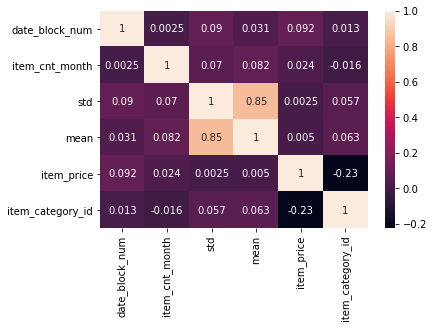

In [71]:
sns.heatmap(corr, annot=True);

# Prediction item_cnt_month using neural networks 

In [69]:
item_cnt_month.head()

,shop_id,date_block_num,item_id,item_cnt_month,std,mean,item_price,item_category_id
0,0,0,32,6.00,3.44,2.34,221.00,40
1,0,0,33,3.00,3.44,2.34,347.00,37
2,0,0,35,1.00,3.44,2.34,247.00,40
3,0,0,43,1.00,3.44,2.34,221.00,40
4,0,0,51,2.00,3.44,2.34,128.50,57


In [73]:
len(shops)

60

In [76]:
len(set(item_cnt_month.item_category_id))

84

In [77]:
item_cnt_month.isna().sum()

shop_id             0
date_block_num      0
item_id             0
item_cnt_month      0
std                 4
mean                0
item_price          0
item_category_id    0
dtype: int64

In [168]:
def build_and_compile_model():
    model = keras.Sequential([
        layers.Dense(64, activation='sigmoid'),
        layers.Dense(16, activation='sigmoid'),
        layers.Dense(16, activation='sigmoid'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.1))
    
    return model

In [169]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [191]:
#for shop_id in shops:
    
shop_data = item_cnt_month[item_cnt_month.shop_id == 25]

X = shop_data.dropna().drop(['shop_id', 'item_id', 'item_cnt_month'], axis=1)
y = shop_data.item_cnt_month

X['date_block_num'] = X['date_block_num'] % 12

categorical_data = X.item_category_id
numerical_data = X.drop('item_category_id', axis=1)

encoder = OneHotEncoder(drop='first')
encoder.fit(pd.DataFrame(categorical_data))

encoded_data = encoder.transform(pd.DataFrame(categorical_data)).toarray()

normalizer = Normalizer()
normalizer.fit(numerical_data)
normalized_data = normalizer.transform(numerical_data)

X = np.concatenate((encoded_data, normalized_data), axis=1)

params = {'n_estimators': range(5, 30, 5), 'max_depth': range(5, 20, 5)}
grid_search = GridSearchCV(RandomForestRegressor(), params, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X, y)



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 20, 5),
                         'n_estimators': range(5, 30, 5)},
             scoring='neg_mean_absolute_error')

In [193]:
abs(grid_search.best_score_)

2.012660321654006

In [134]:
X

array([[0.   , 0.   , 0.   , ..., 0.003, 0.004, 1.   ],
       [0.   , 0.   , 0.   , ..., 0.001, 0.002, 1.   ],
       [0.   , 0.   , 0.   , ..., 0.003, 0.004, 1.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.009, 0.007, 0.999],
       [0.   , 0.   , 0.   , ..., 0.014, 0.01 , 0.998],
       [0.   , 0.   , 0.   , ..., 0.004, 0.003, 1.   ]])

In [135]:
y

64224   5.00
64225   3.00
64226   2.00
64227   3.00
64228   1.00
        ... 
88327   1.00
88328   5.00
88329   1.00
88330   1.00
88331   1.00
Name: item_cnt_month, Length: 24108, dtype: float64

In [111]:
normalized_data

array([[0.003, 0.003, 0.004, 1.   ],
       [0.001, 0.001, 0.002, 1.   ],
       [0.003, 0.003, 0.004, 1.   ],
       ...,
       [0.036, 0.009, 0.007, 0.999],
       [0.053, 0.014, 0.01 , 0.998],
       [0.016, 0.004, 0.003, 1.   ]])

In [121]:
normalized_data.shape

(24108, 4)

In [115]:
encoded_data.shape

(24108, 59)

In [116]:
encoded_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [120]:
np.concatenate((encoded_data, normalized_data), axis=1).shape

(24108, 63)